In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [0]:
def k_means(img, cluster_count, colours):
    
    # Getting image dimensions
    x, y, depth = img.shape
    img = img/255.0  # normalize to [0,1]
    
    # Generate random clusters within image
    # method 1: random
#     clusters = np.random.rand(cluster_count, depth)
    
    # method 2: random but within img space
    cluster_x_idx = np.random.randint(low=0, high=x, size=(cluster_count))
    cluster_y_idx = np.random.randint(low=0, high=y, size=(cluster_count))
    
    clusters = []
    for idx in range(cluster_count):
        clusters.append(img[cluster_x_idx[idx]][cluster_y_idx[idx]])
    clusters = np.asarray(clusters)
    
    # method 3: definite within img space
    
    # Create cluster mapping
    cluster_mapping = np.zeros((x, y))
    
    error_threshold = 0.5
    error = error_threshold + 0.5
    
    while error > error_threshold:
        
        # Assign clusters
        cluster_mapping = assign_clusters(img, clusters, cluster_mapping, x, y)
        
        # Get new clusters
        clusters, error = update_clusters(img, clusters, cluster_mapping, x, y)
    
    plot_clusters(img, cluster_mapping.astype(int), x, y, colours, cluster_count)
    return cluster_mapping.astype(int)


def plot_clusters(img, cluster_mapping, x_size, y_size, colours, cluster_count):

    # Create segmented image and set colors
    img_segmented = np.copy(img)
    img_segmented.setflags(write=1)
    
    for y in range(0, y_size):
        for x in range(0, x_size):
            img_segmented[x][y] = colours[cluster_mapping[x][y] % len(colours)]
    
    # Plotting
    plt.subplot(1, 2, 1)
    plt.imshow(img, zorder=1)
    plt.subplot(1, 2, 2)
    plt.imshow(img_segmented, alpha=1, zorder=2)
    
    plt.savefig('./cluster{}.png'.format(cluster_count))
    plt.show()
    plt.clf()


def assign_clusters(img, clusters, cluster_mapping, x_size, y_size):
    for y in range (0, y_size):
        for x in range (0, x_size):
            
            # Getting RGB vector of pixel
            pixel = img[x][y]
            
            # Find closest RGB colour-space cluster
            cluster_index = closest_cluster(pixel, clusters)
            
            # Update cluster mapping accordingly
            cluster_mapping[x, y] = cluster_index
            
    return cluster_mapping


def closest_cluster(pixel, clusters):
    return np.linalg.norm(clusters - pixel, axis=1).argmin()


def update_clusters(img, clusters, cluster_mapping, x_size, y_size):
  
    old_clusters = np.copy(clusters)
    
    for index, cluster in enumerate(clusters):
      
        # Find all pixels belonging to this cluster
        pixels = [img[x][y] for y in range (0, y_size) for x in range (0, x_size) if cluster_mapping[x][y] == index]
        
        if len(pixels) > 0:
            clusters[index] = np.mean(pixels)
    
    error = np.linalg.norm(clusters - old_clusters)
    return clusters, error


def get_rgb(colours):
    colour_dict = {
        'r': [255, 0 ,0],
        'g': [0, 255, 0],
        'b': [0, 0, 255],
        'y': [255, 255, 0],
        'c': [0, 255, 255],
        'm': [255, 0, 255]
    }
    colours_rgb = []
    for colour in colours:
        colours_rgb.append(colour_dict[colour])
    return colours_rgb


def generate_baseline(img, cluster_count=3):
    colours_rgb = get_rgb(['r','g','b','y','c','m'])
    return k_means(img, cluster_count, colours_rgb)

In [0]:
def get_central_weight(width, height):
    central_weights = np.ones((width, height))
    
    center_x, center_y = int(width/2), int(height/2)
    
    max_x_dist, max_y_dist = max(center_x-0, width-center_x), max(center_y-0, height-center_y)
    
    for x in range(width):
        for y in range(height):
            x_dist, y_dist = abs(x-center_x), abs(y-center_y)
            normalized_x_dist, normalized_y_dist = x_dist/max_x_dist, y_dist/max_y_dist
            normalized_dist = max(normalized_x_dist, normalized_y_dist)
            central_weights[x][y] -= normalized_dist
    
    return central_weights

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


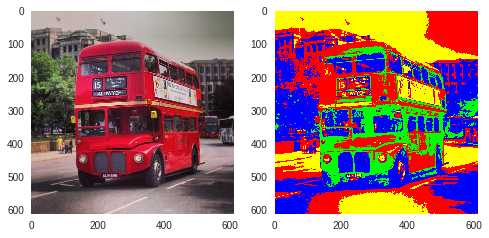

<Figure size 576x396 with 0 Axes>

In [4]:
cluster_count = 4
image_path = '000000001584.jpg'
cluster_mapping = generate_baseline(mpimg.imread(image_path), cluster_count=cluster_count)

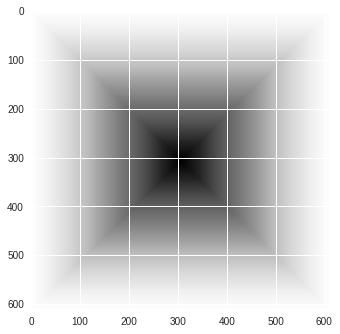

In [5]:
# Create weights with center-priority

width = cluster_mapping.shape[0]
height = cluster_mapping.shape[1]

central_weights = get_central_weight(width, height)
plt.imshow(central_weights)

In [0]:
# Calculate each segments prominence score

cluster_score = np.zeros((cluster_count))
cluster_masks = np.zeros((cluster_count,width,height), dtype=np.int)

for cluster in range(cluster_count):
    for x in range(width):
        for y in range(height):
            cluster_masks[cluster][x][y] = 1 if (cluster_mapping[x][y] == cluster) else 0
    
    weighted_cluster = np.multiply(cluster_masks[cluster], central_weights)
    cluster_score[cluster] = weighted_cluster.sum() / np.sqrt(cluster_masks[cluster].sum())

#     plt.imshow(cluster_masks[cluster])
#     plt.imshow(weighted_cluster)

0


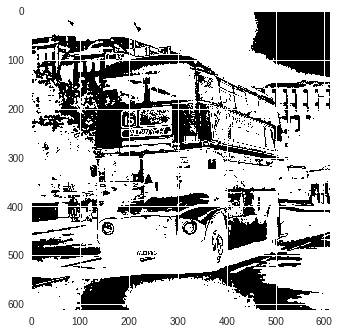

In [7]:
# Identify image mask of most prominent segment

prominent_idx = np.argmax(cluster_score)
print(prominent_idx)
image_mask = cluster_masks[prominent_idx]
plt.imshow(image_mask)

image_mask = np.expand_dims(image_mask,-1)

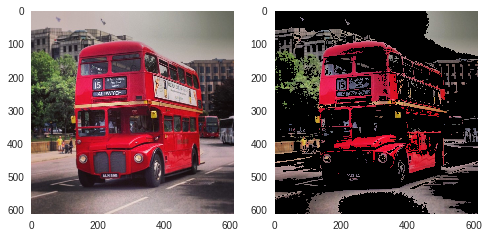

<Figure size 576x396 with 0 Axes>

In [8]:
# Apply mask and display image

img = mpimg.imread(image_path)
new_img = np.zeros((width, height, 3), dtype=np.uint8)

for x in range(width):
    for y in range(height):
        if image_mask[x][y] == 1:
            new_img[x][y] = img[x][y]
        elif image_mask[x][y] < 1:
            new_img[x][y] = 0

# Plotting
plt.subplot(1, 2, 1)
plt.imshow(img, zorder=1)
plt.subplot(1, 2, 2)
plt.imshow(new_img, alpha=1, zorder=2)

plt.savefig('./segmented{}.png'.format(cluster_count))
plt.show()
plt.clf()